In [2]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [4]:
load_dotenv(override=True)
open_ai_api_key = os.getenv('OPENAI_API_KEY')

In [5]:
Model = "gpt-4o-mini"
openai= OpenAI()

In [6]:
system_message="You are a helpful assistant for FlightAI airline company"
system_message += "Give short and concise answers to questions"
system_message += "If you don't know the answer just say I dont know"

In [10]:
def chat(message,history):
    messages = [{"role":"system","content":system_message}] + history+ [{"role":"user","content":message}]
    response = openai.chat.completions.create(model=Model,messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch() 

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Tools:

Tools are functions/objects that allows the LLMs to utilize external sources of information and perform tasks i.e. searching latest info, performing a task based on some information etc

In [16]:
ticket_prices = {"london":"$1000", "tokyo":"$550" , "newyork":"$799"}

def get_ticket_price(destination):
    city=destination.lower()
    return ticket_prices.get(city,"Unkown")

In [17]:
get_ticket_price("newyork")


'$799'

In [23]:
price_function = {
    "name":"get_ticket_price",
    "description":"Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters":{
    "type":"object",
    "properties":{
        "destination":{
            "type":"string",
            "description":"city the customer wants to travel to",
        },
    },
    "required": ["destination_city"],
        "additionalProperties": False
    
}

}


In [24]:
tools = [{"type": "function", "function": price_function}]

In [26]:
def chat(message,history):
    messages = [{"role":"system","content": system_message}]+history+[{"role":"user","content":message}]
    response = openai.chat.completions.create(model=Model,messages=messages,tools=tools)

    if response.choices[0].finish_reason == "tool_calls":
        message=response.choices[0].message
        response,city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=Model, messages=messages)

    return response.choices[0].message.content

In [27]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [28]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Multi-Modality!

In [29]:
import base64
from io import BytesIO
from PIL import Image

In [32]:
def artist(city):
    image_response = openai.images.generate(
        model = "dall-e-3",
        prompt = f"Can you create an image for me representing vacation in {city}, showing unique attractions about it and living style of natives as well",
        size = "1024x1024",
        n=1,
        response_format="b64_json",
            )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))
    

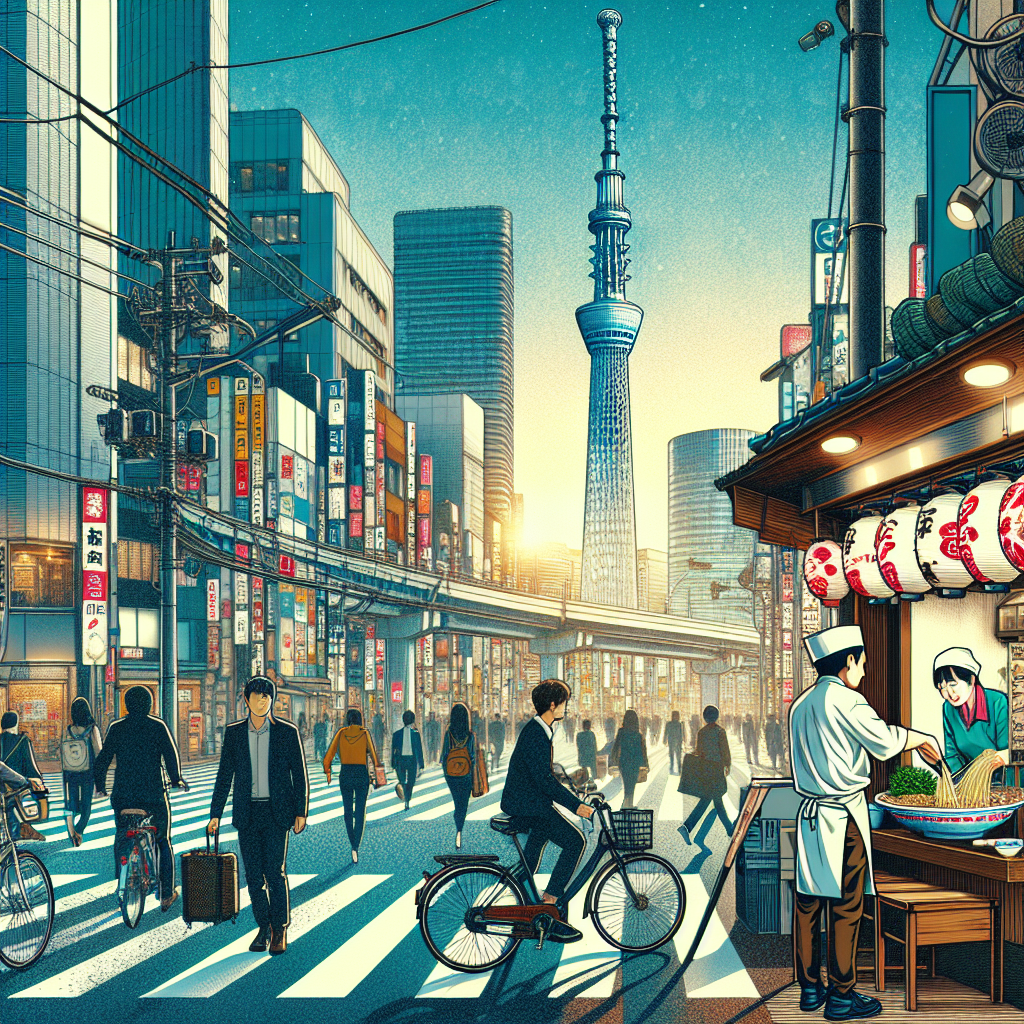

In [36]:
image= artist("tokyo")
display(image)